In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import glob
import os
import feather
from sklearn.pipeline import make_pipeline
from sktime.datasets import load_from_tsfile_to_dataframe
sns.set(style="whitegrid")

--------------------------------------

### Preparing the frames to store information

In [2]:
# row corresponds to classifier, col to dataset
accuracy = pd.DataFrame(columns=datasets)

In [3]:
classifiers = ['RF_sumCl', 
               'RF_sklearn', 
               'RF_catch22',
               'RF_kats',
               'RF_tsfeatures',
               'RF_tsfel',
               'RF_tsfresh']

Adiac_pred        = pd.DataFrame(columns=classifiers)
Fish_pred         = pd.DataFrame(columns=classifiers)
OliveOil_pred     = pd.DataFrame(columns=classifiers)
Phoneme_pred      = pd.DataFrame(columns=classifiers)
ShapesAll_pred    = pd.DataFrame(columns=classifiers)
SwedishLeaf_pred  = pd.DataFrame(columns=classifiers)
WordSynonyms_pred = pd.DataFrame(columns=classifiers)

predictionFrames = [Adiac_pred,
                    Fish_pred,
                    OliveOil_pred,
                    Phoneme_pred,
                    ShapesAll_pred,
                    SwedishLeaf_pred,
                    WordSynonyms_pred]

--------------------------------------

### Starting with SKTIME

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sktime.classification.feature_based import SummaryClassifier

sklearn_classifier = RandomForestClassifier()
sc_classifier       = SummaryClassifier(estimator=sklearn_classifier)

In [5]:
score2 = []

for dataset, i in zip(datasets, range(len(predictionFrames))):
    print(dataset)
    
    # load training data
    X_train, y_train = load_from_tsfile_to_dataframe('data/' + dataset + '_TRAIN.ts')

    # load test data
    X_test, y_test = load_from_tsfile_to_dataframe('data/' + dataset + '_TEST.ts')
    
    ############################
    # sktime - SummaryClassifier
    
    if dataset == 'Phoneme':
        score2.append(np.nan)
        continue
    else:
        sc_classifier.fit(X_train, y_train)
        score2.append(sc_classifier.score(X_test, y_test))
        predictionFrames[i][classifiers[0]] = sc_classifier.predict(X_test)

Adiac
Fish
OliveOil
Phoneme
ShapesAll
SwedishLeaf
WordSynonyms


In [6]:
accuracy.loc[0] = score2

In [7]:
accuracy

,Adiac,Fish,OliveOil,Phoneme,ShapesAll,SwedishLeaf,WordSynonyms
0,0.654731,0.542857,0.633333,NaN,0.543333,0.6544,0.291536


--------------------------------------

### SKLEARN - basic

In [8]:
def getFrame(dataset, labels):
    
    # stores series 
    finalFrame = pd.DataFrame()
    
    for row in dataset.iterrows():
        finalFrame = pd.concat([finalFrame, row[1].values[0].to_frame().T], ignore_index=True)
    
    # adds labels at the end of the frame
    finalFrame['label'] = [int(i) for i in labels]

    return finalFrame

In [9]:
score3 = []

for dataset, i in zip(datasets, range(len(predictionFrames))):
    
    # load training data
    X_train, y_train = load_from_tsfile_to_dataframe('data/' + dataset + '_TRAIN.ts')
    trainData = getFrame(X_train, y_train)

    # load test data
    X_test, y_test = load_from_tsfile_to_dataframe('data/' + dataset + '_TEST.ts')
    testData = getFrame(X_test, y_test)
    
    sklearn_classifier.fit(trainData.iloc[:, :-1], trainData['label'])
    score3.append(sklearn_classifier.score(testData.iloc[:, :-1], testData['label']))
    predictionFrames[i][classifiers[1]] = sklearn_classifier.predict(testData.iloc[:, :-1])

In [10]:
accuracy.loc[1] = score3
accuracy

,Adiac,Fish,OliveOil,Phoneme,ShapesAll,SwedishLeaf,WordSynonyms
0,0.654731,0.542857,0.633333,NaN,0.543333,0.6544,0.291536
1,0.624041,0.822857,0.900000,0.136603,0.738333,0.8704,0.562696


--------------------------------------

### SKLEARN x Features

In [12]:
j = 2
for ex, name in zip(extractors, classifiers[-5:]) :
    scoreX = []
    
    for dataset, i in zip(datasets, range(len(predictionFrames))):
        
        train = ex.loc[(ex['data'] == dataset) & (ex['set'] == 'train')]
        test  = ex.loc[(ex['data'] == dataset) & (ex['set'] == 'test')]
        
        sklearn_classifier.fit(train.iloc[:, :-3], train['label'])
        scoreX.append(sklearn_classifier.score(test.iloc[:, :-3], test['label']))
        
        pred = sklearn_classifier.predict(test.iloc[:, :-3])
        
        if len(pred) == len(predictionFrames[i][name]):
            predictionFrames[i][name] = pred
        else:
            continue
        
    accuracy.loc[j] = scoreX
    j += 1

In [13]:
accuracy

,Adiac,Fish,OliveOil,Phoneme,ShapesAll,SwedishLeaf,WordSynonyms
0,0.654731,0.542857,0.633333,NaN,0.543333,0.654400,0.291536
1,0.624041,0.822857,0.900000,0.136603,0.738333,0.870400,0.562696
2,0.708440,0.754286,0.800000,0.300105,0.781667,0.891200,0.542320
3,0.718670,0.708571,0.666667,0.309599,0.793333,0.916800,0.534483
4,0.727979,0.737143,0.633333,0.307651,0.764103,0.915858,0.503949
5,0.787724,0.771429,0.933333,0.338080,0.825000,0.931200,0.537618
6,0.800512,0.868571,0.900000,0.319958,0.821667,0.931200,0.574803


--------------------------------------

### Plotting accuracy

#### Plot for each dataset

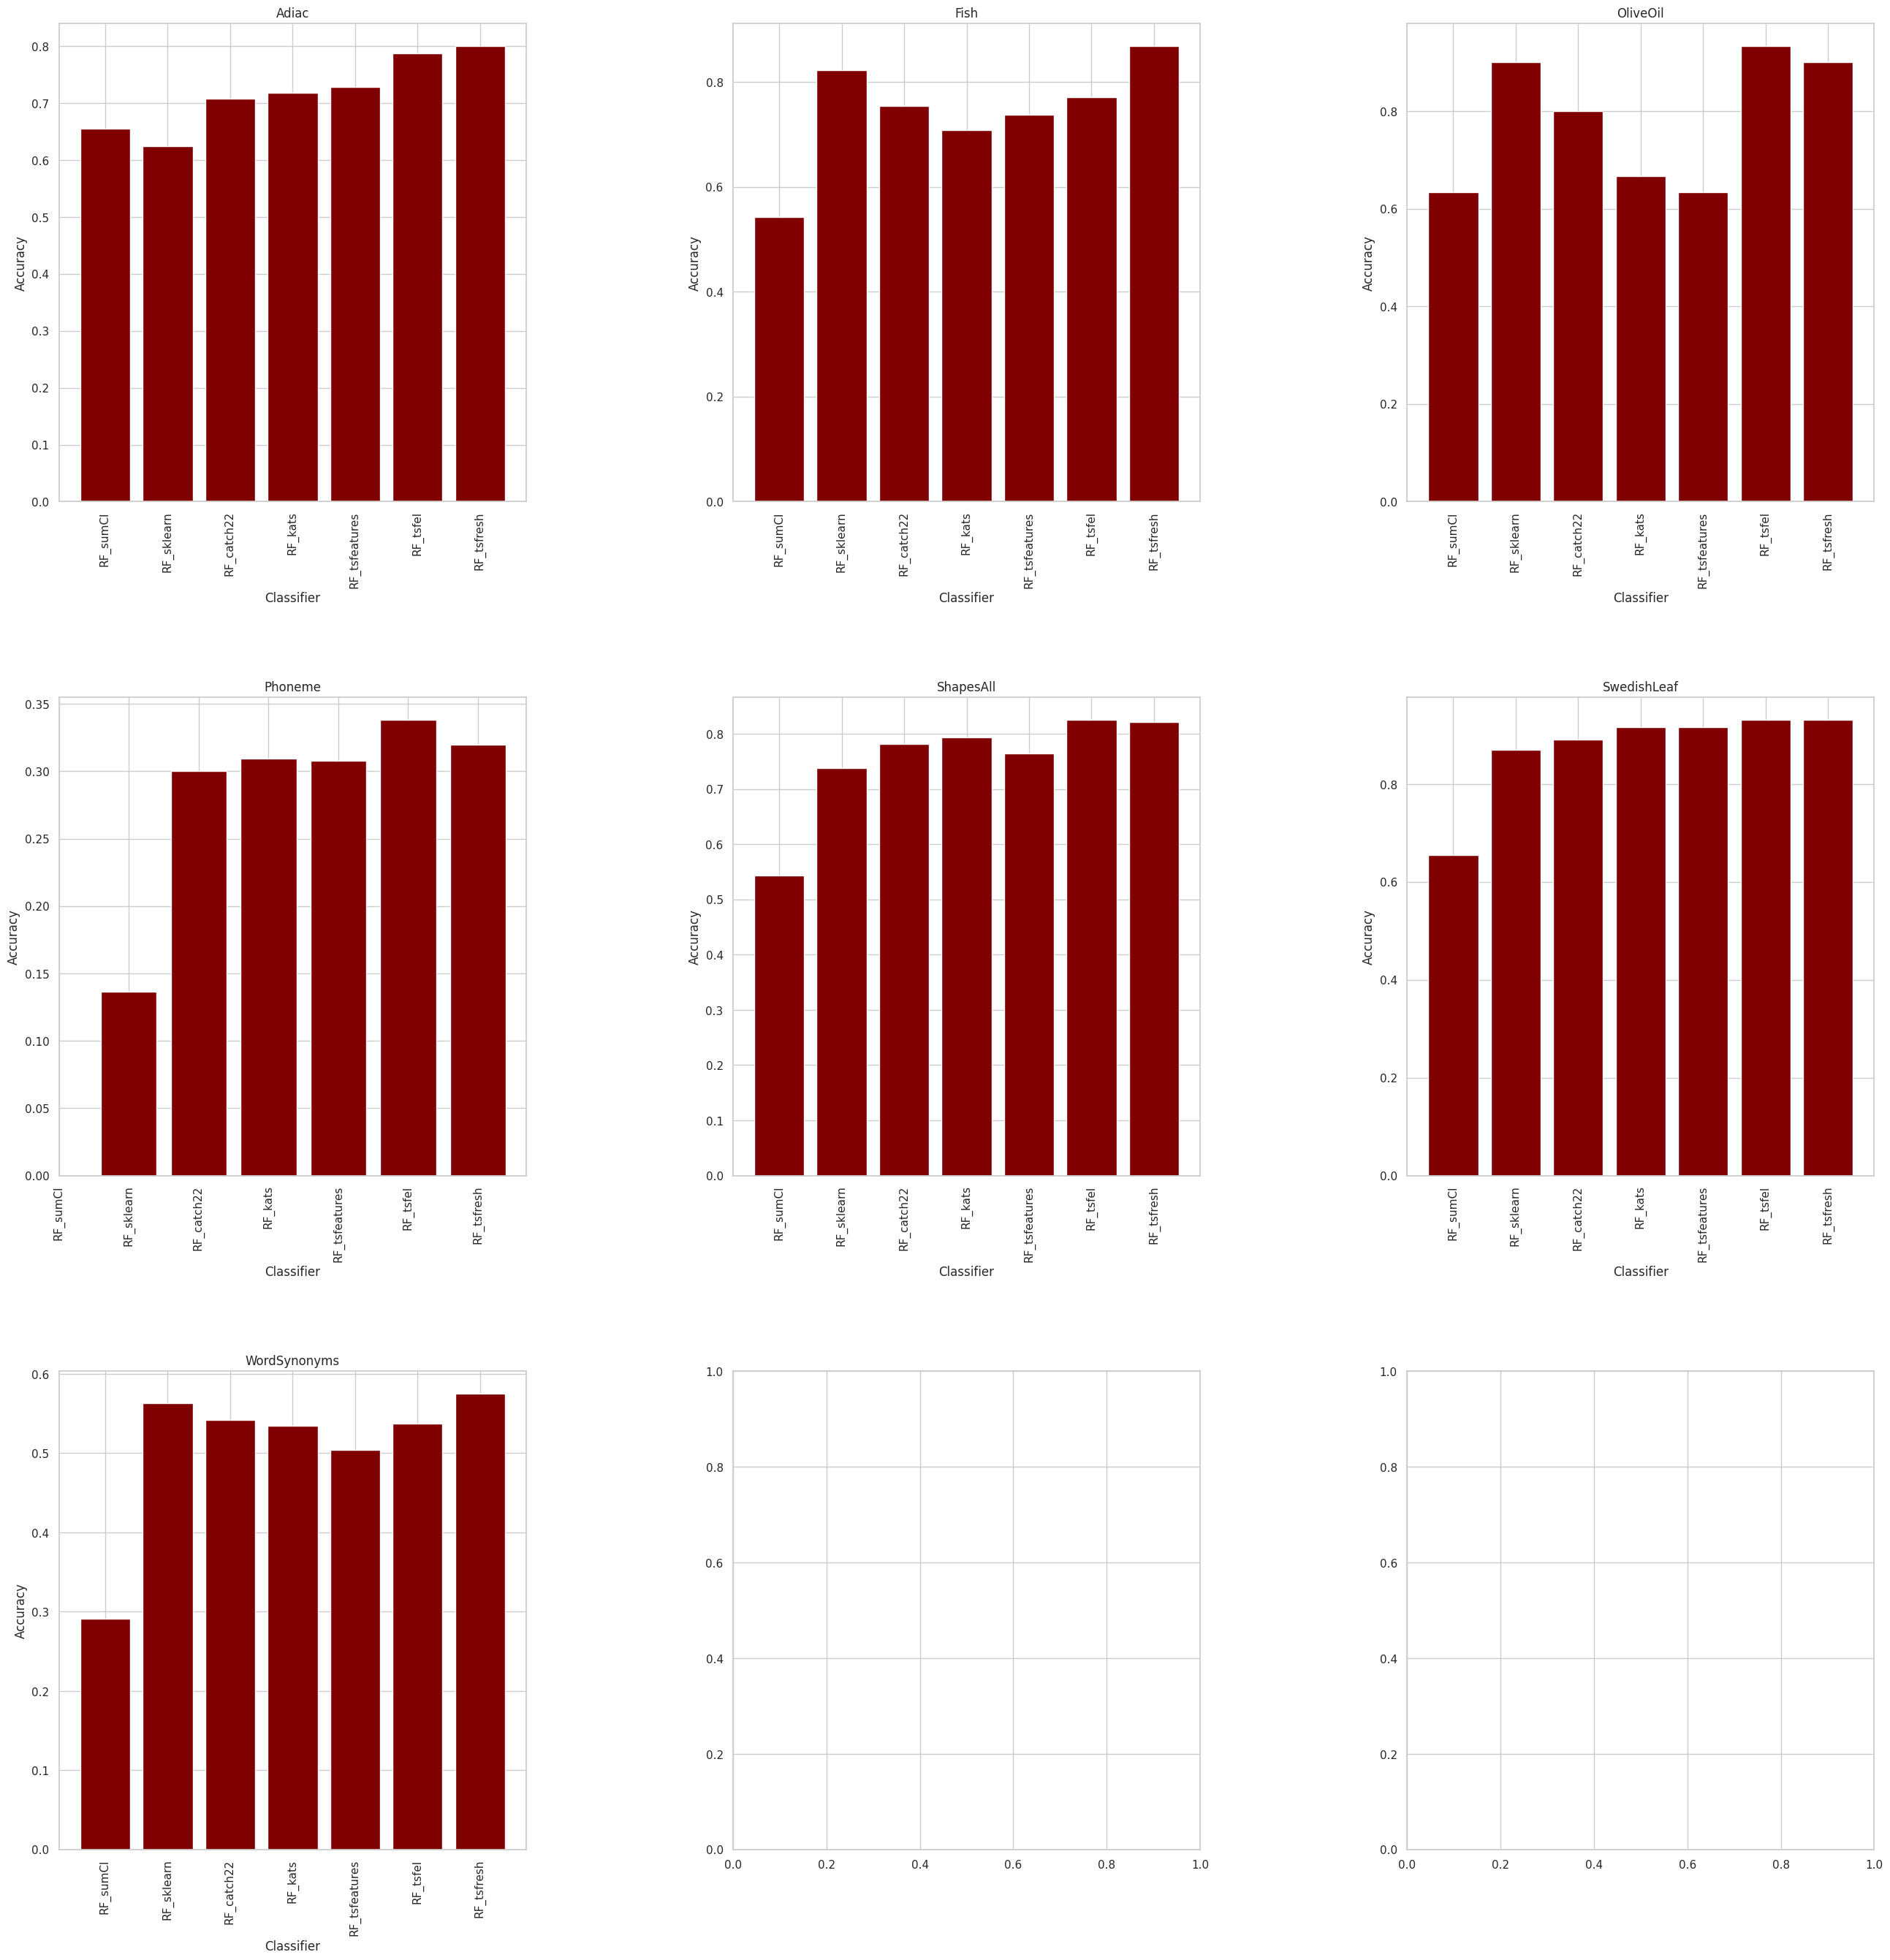

In [16]:
plotAccuracy(accuracy, classifiers, True)

#### Plot for each classifier

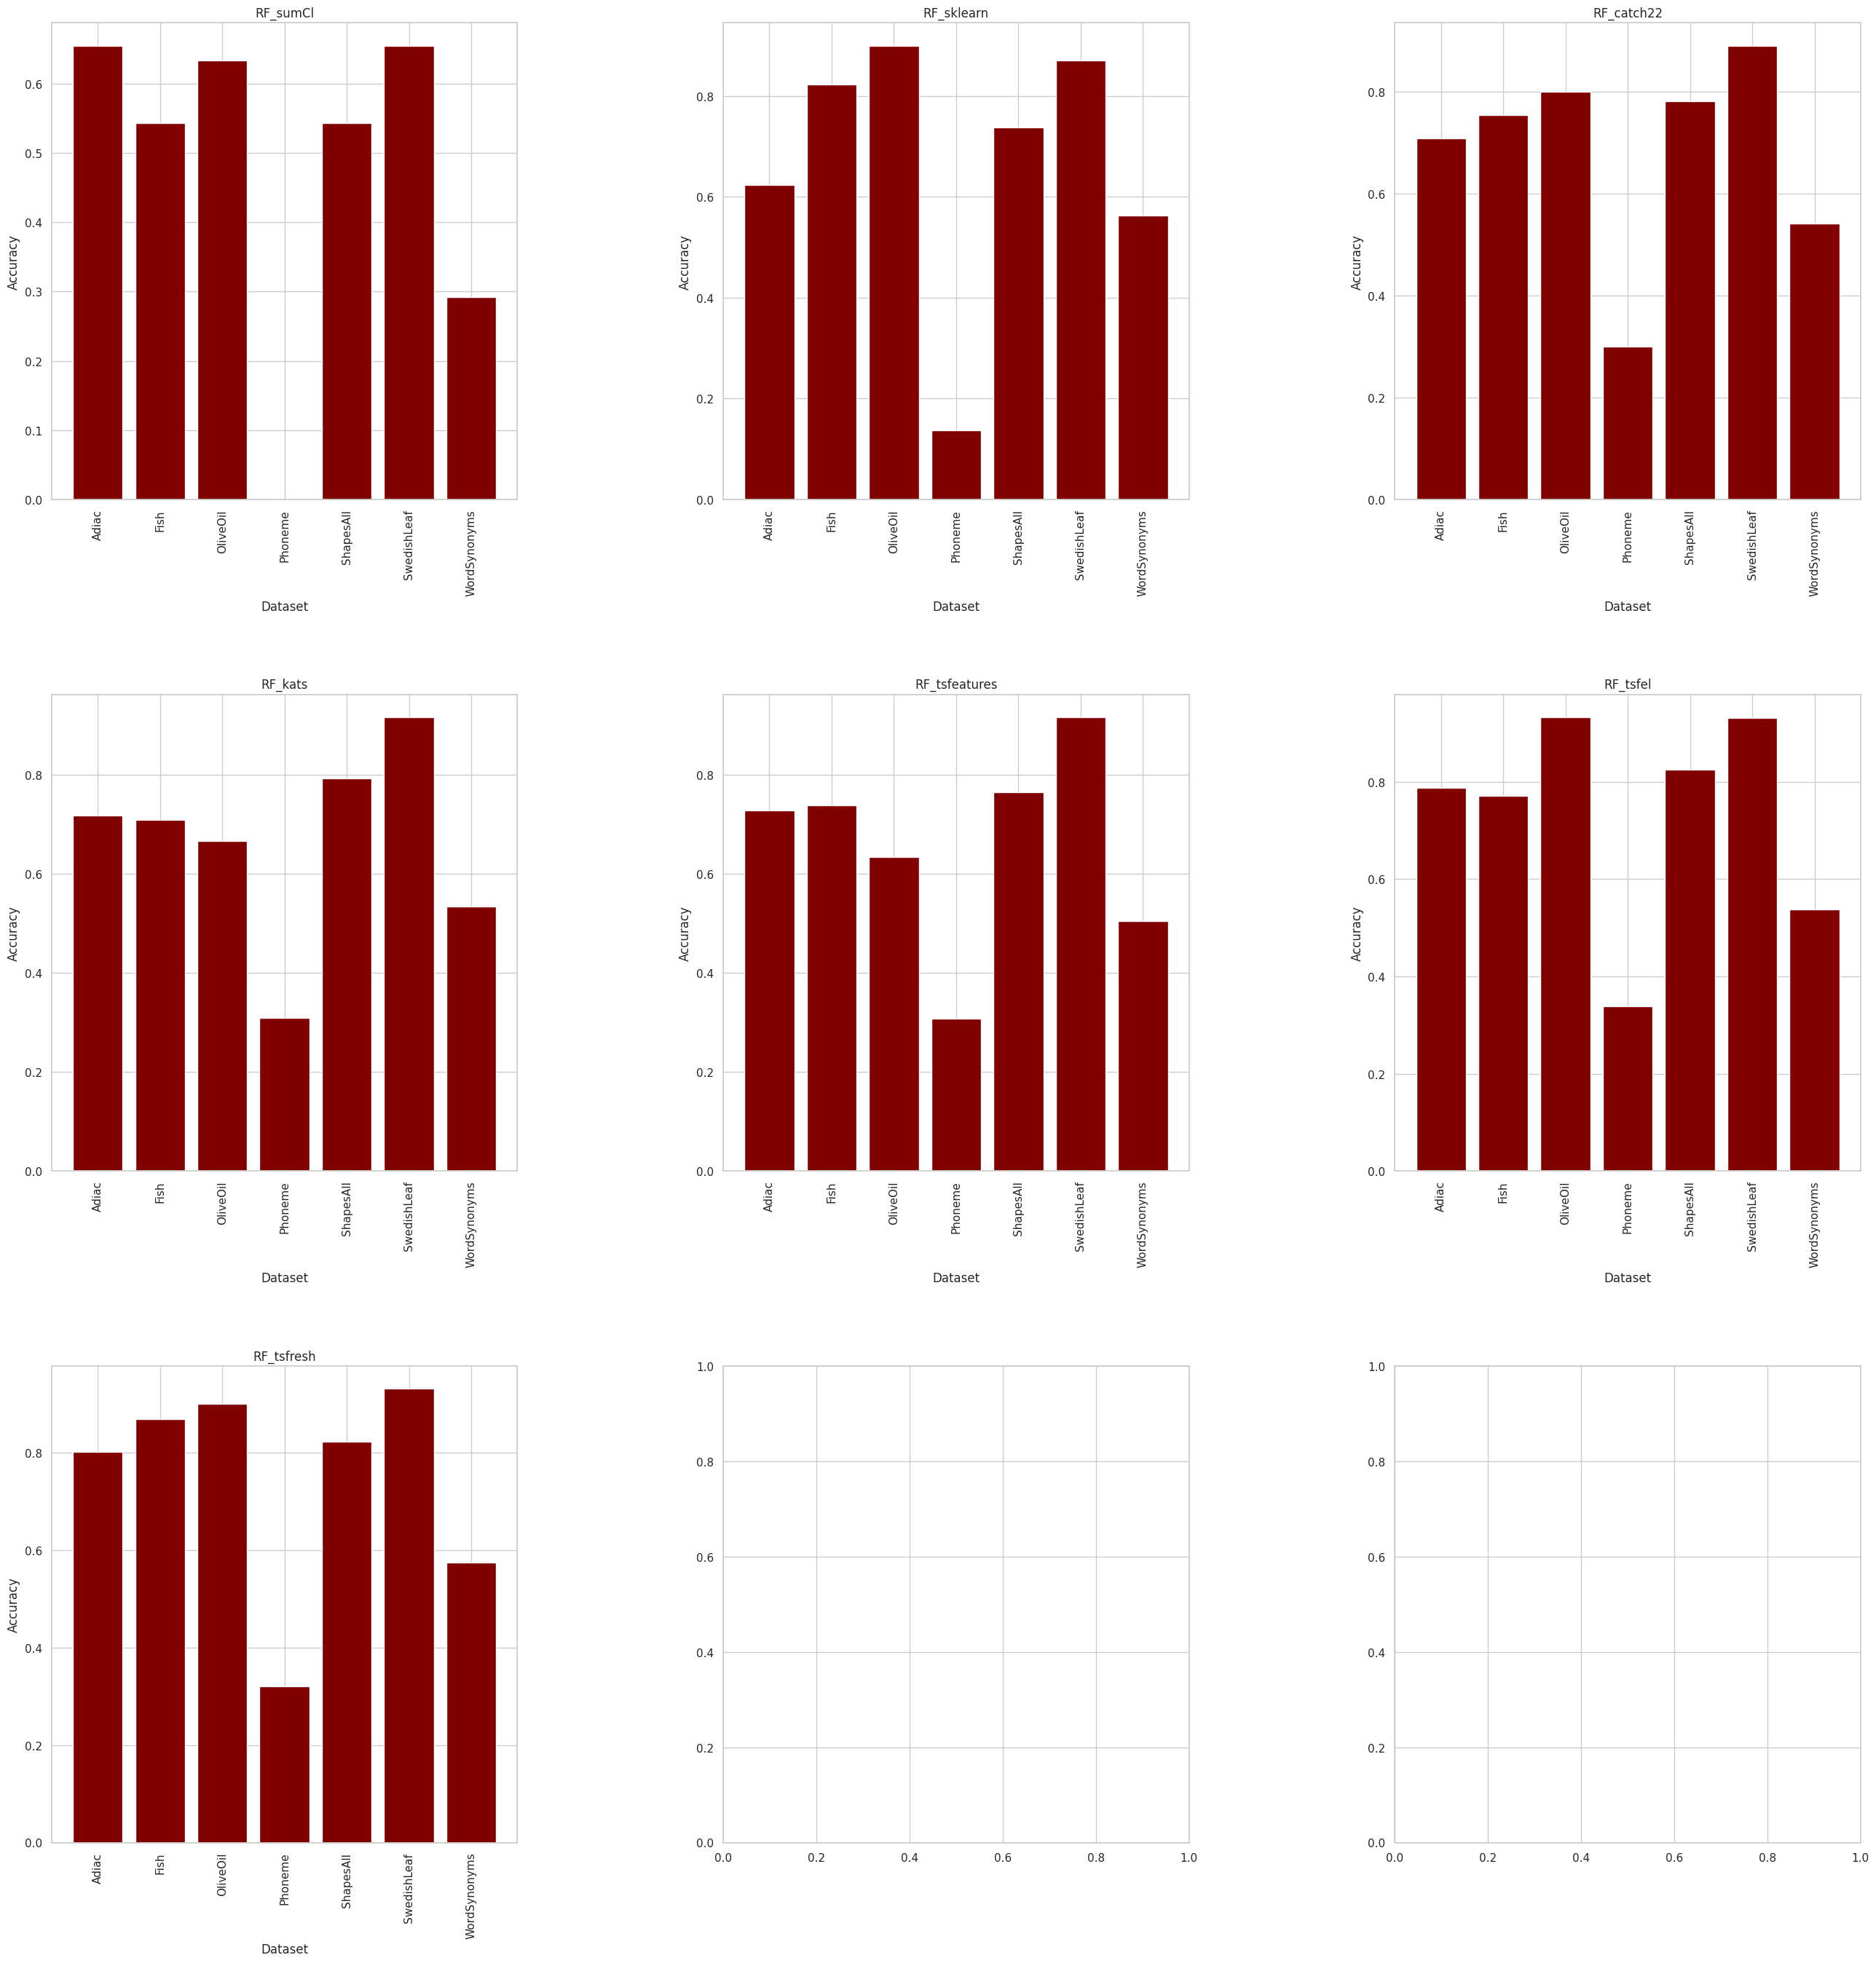

In [17]:
plotAccuracy(accuracy, classifiers, False)

--------------------------------------